# Import Library

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Input

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# Data Loading 

In [2]:
df = pd.read_csv("../../SleepEfficiency/Dataset/Sleep_Efficiency.csv")

# Inital Analysis

In [3]:
new_columns = ['id', 'age', 'gender','bed_time', 'wakeup_time', 'sleep_dur', 'sleep_eff', 'rem_per', 'deep_per', 'light_per', 'awake',
               'caffeine', 'alcohol', 'smoke_stat', 'exercise_freq']
df.columns = new_columns
df = df.drop(columns=['id','bed_time', 'wakeup_time'])
df.sample(5)

,age,gender,sleep_dur,sleep_eff,rem_per,deep_per,light_per,awake,caffeine,alcohol,smoke_stat,exercise_freq
136,52,Male,7.0,0.90,26,63,18,0.0,NaN,3.0,Yes,1.0
220,37,Female,7.0,0.77,28,57,21,4.0,0.0,0.0,No,4.0
308,56,Female,7.0,0.93,20,65,15,1.0,0.0,5.0,No,3.0
143,25,Male,7.0,0.87,27,55,18,NaN,0.0,3.0,No,3.0
253,46,Female,6.0,0.95,30,60,10,0.0,0.0,0.0,No,3.0


In [4]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            452 non-null    int64  
 1   gender         452 non-null    object 
 2   sleep_dur      452 non-null    float64
 3   sleep_eff      452 non-null    float64
 4   rem_per        452 non-null    int64  
 5   deep_per       452 non-null    int64  
 6   light_per      452 non-null    int64  
 7   awake          432 non-null    float64
 8   caffeine       427 non-null    float64
 9   alcohol        436 non-null    float64
 10  smoke_stat     452 non-null    object 
 11  exercise_freq  446 non-null    float64
dtypes: float64(6), int64(4), object(2)
memory usage: 42.5+ KB
None


,age,sleep_dur,sleep_eff,rem_per,deep_per,light_per,awake,caffeine,alcohol,exercise_freq
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,436.000000,446.000000
mean,40.285398,7.465708,0.788916,23.002212,52.960177,24.831858,1.641204,23.653396,1.245413,1.791480
std,13.172250,0.866625,0.135237,3.972466,15.561713,15.150774,1.356762,30.202785,1.643336,1.428134
min,9.000000,5.000000,0.500000,15.000000,20.000000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,7.000000,0.697500,20.000000,51.250000,15.000000,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.500000,0.820000,22.000000,60.000000,18.000000,1.000000,25.000000,0.000000,2.000000
75%,52.000000,8.000000,0.900000,27.000000,63.000000,27.250000,3.000000,50.000000,2.000000,3.000000
max,69.000000,10.000000,0.990000,30.000000,75.000000,56.000000,4.000000,200.000000,5.000000,5.000000


### Split Numerical and Categorical Columns (1)

In [5]:
numerical_columns = [column for column in df.columns if df[column].dtype != 'object']
print(numerical_columns)

categorical_columns = [column for column in df.columns if df[column].dtype == 'object']
print(categorical_columns)

['age', 'sleep_dur', 'sleep_eff', 'rem_per', 'deep_per', 'light_per', 'awake', 'caffeine', 'alcohol', 'exercise_freq']
['gender', 'smoke_stat']


### Fill Null Value

In [6]:
def set_fillna(df, numerical_columns):
    df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
    return df

df = set_fillna(df, numerical_columns)

### Change Columns Dtypes

In [7]:
def set_types(df):
    df['age']           = df['age'].astype('int8')
    df['gender']        = df['gender'].astype('category')
    df['sleep_dur']     = df['sleep_dur'].astype('float16')
    df['sleep_eff']     = df['sleep_eff'].astype('float16')
    df['rem_per']       = df['rem_per'].astype('int8')
    df['deep_per']      = df['deep_per'].astype('int8')
    df['light_per']     = df['light_per'].astype('int8')
    df['awake']         = df['awake'].astype('int8')
    df['caffeine']      = df['caffeine'].astype('int8')
    df['alcohol']       = df['alcohol'].astype('int8')
    df['smoke_stat']    = df['smoke_stat'].map({'Yes': 1, 'No':0}).astype('int8')
    df['exercise_freq'] = df['exercise_freq'].astype('int8')
    return df

df = set_types(df)

### Split Numerical and Categorical Columns (2)

In [8]:
numerical_columns = [column for column in df.columns if df[column].dtype != 'category']
print(numerical_columns)

categorical_columns = [column for column in df.columns if df[column].dtype == 'category']
print(categorical_columns)

['age', 'sleep_dur', 'sleep_eff', 'rem_per', 'deep_per', 'light_per', 'awake', 'caffeine', 'alcohol', 'smoke_stat', 'exercise_freq']
['gender']


# Data Exploration 

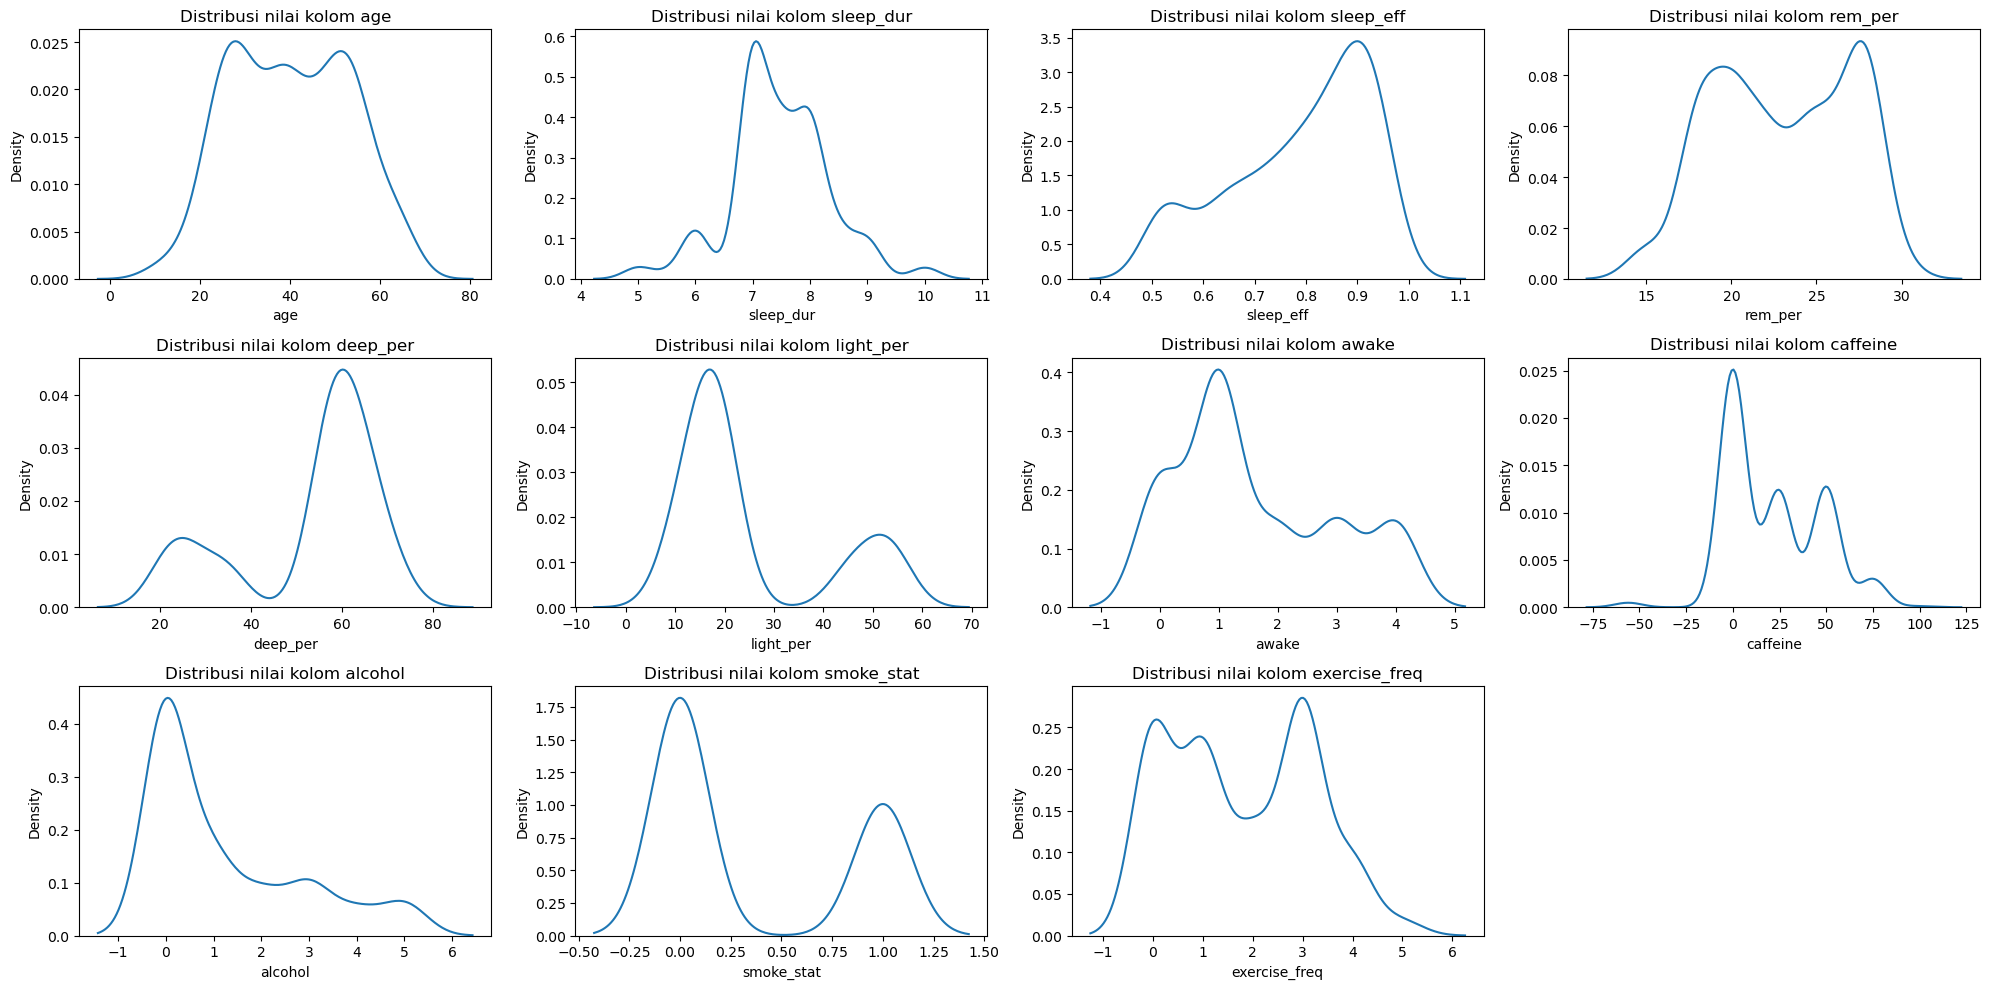

In [9]:
num_rows = 3
num_cols = math.ceil(len(numerical_columns) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=df, x=column, ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

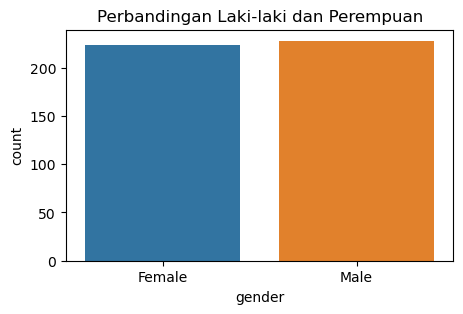

In [10]:
for column in categorical_columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[column]).set_title("Perbandingan Laki-laki dan Perempuan")
    plt.show()

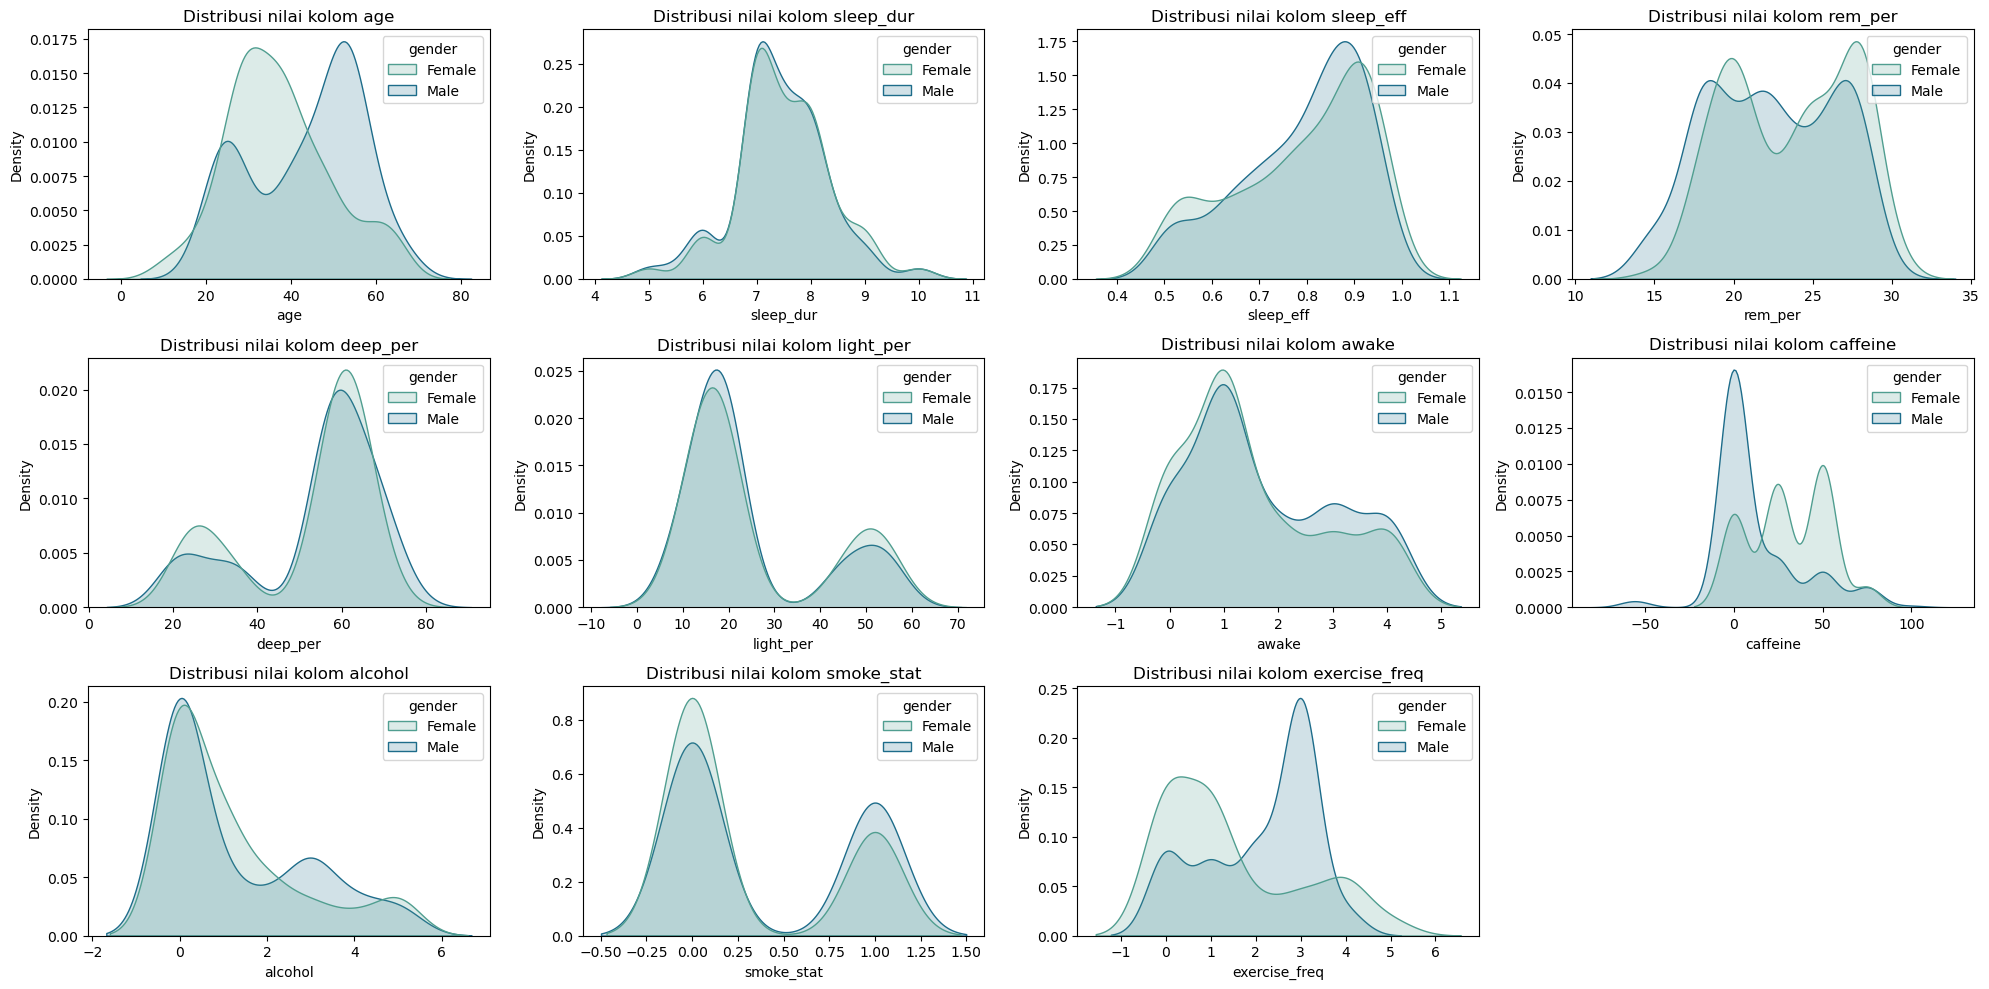

In [11]:
num_rows = 3
num_cols = math.ceil(len(numerical_columns) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=df, x=column, hue="gender", fill=True, alpha=.2, palette="crest", ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

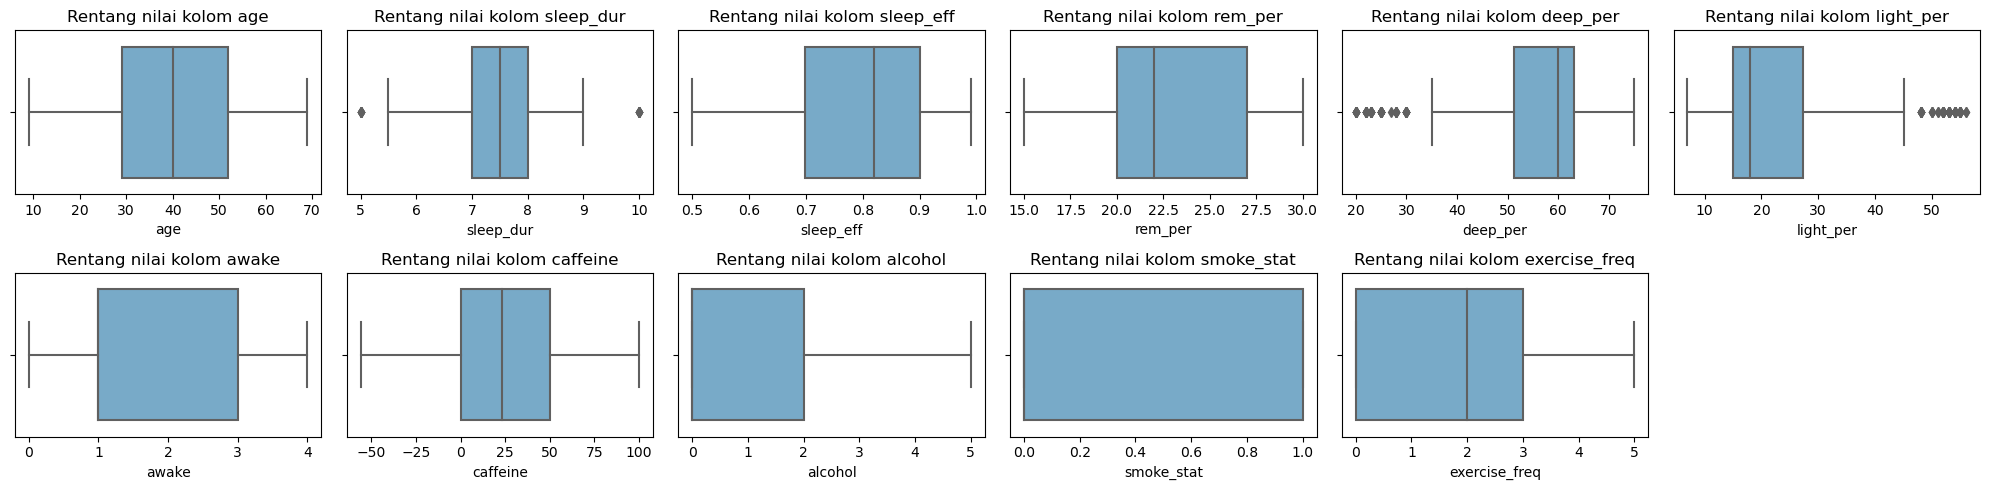

In [12]:
num_rows = 2
num_cols = math.ceil(len(numerical_columns) / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=df[column], ax=axes[row, col], palette="Blues").set_title("Rentang nilai kolom " + column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Data Correlation

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

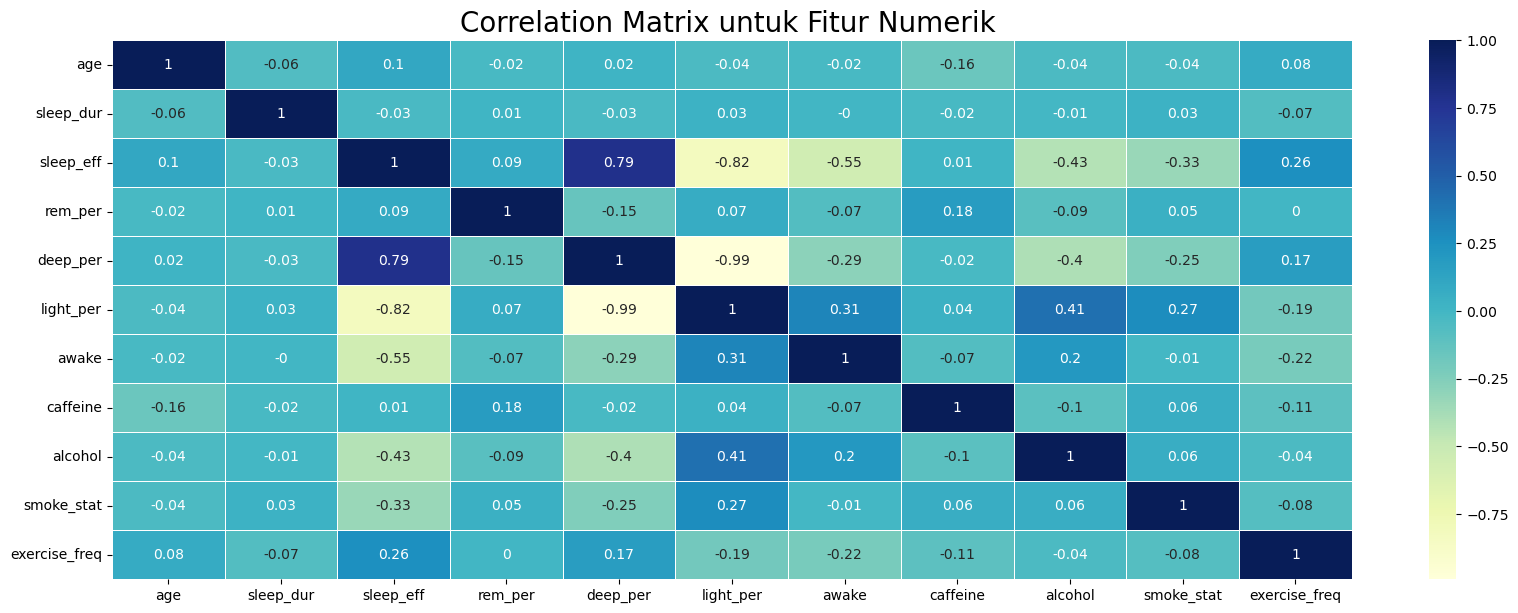

In [13]:
corr_matrix = df[numerical_columns].corr().round(2)

plt.figure(figsize=(20, 7))
sns.heatmap(data=corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

# Data Preprocessing

In [14]:
X = df[numerical_columns].drop(columns='sleep_eff')
Y = df['sleep_eff']

# scaler = StandardScaler()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 452
Total # of sample in train dataset: 384
Total # of sample in test dataset: 68


# Model Prediction using Regression Algorithms

### Finding optimal parameter for Regression Algorithms

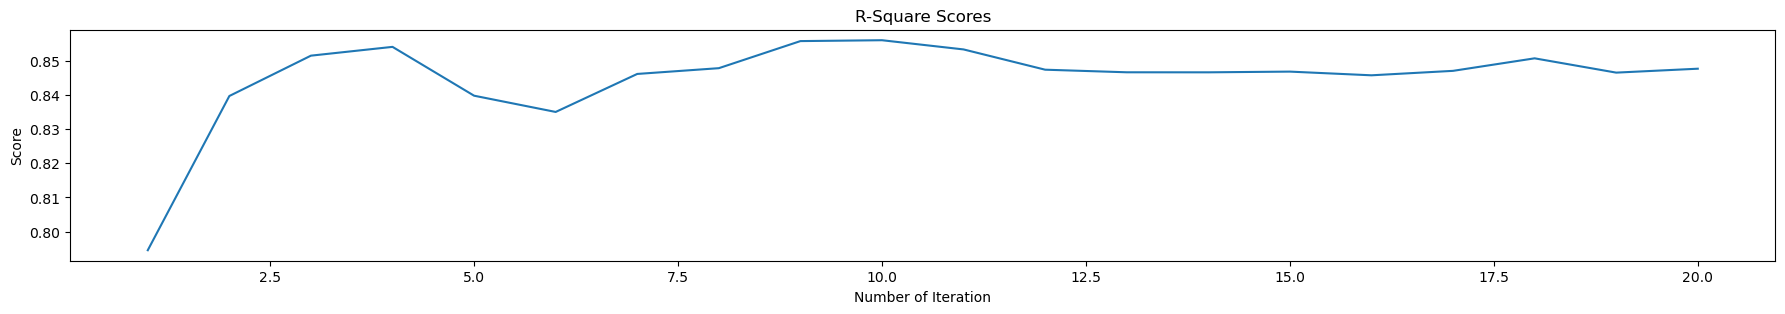

CPU times: total: 109 ms
Wall time: 132 ms


In [84]:
%%time
mse_value = []
r2_value = []
n_number = 20
for i in range(n_number):
    model = KNeighborsRegressor(n_neighbors=i+1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).astype('float16')
 
    # Calculate the mean squared error (MSE) and the R-squared score
    mse = mean_squared_error(y_test, y_pred)
    mse_value.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_value.append(r2)

# Create a figure and axis
plt.figure(figsize=(22, 3))
plt.plot(range(1, n_number+1), r2_value)
plt.title('R-Square Scores')
plt.xlabel('Number of Iteration')
plt.ylabel('Score')
plt.show()

### Regression Algorithms Model Preparation

In [21]:
def regression_algorithms():
    algorithms = [
                  ('Linear Regression', LinearRegression()), 
                  ('Lasso Regression', Lasso(alpha=0.0001)),
                  ('Ridge Regression', Ridge(alpha=0.1)),
                  ('ElasticNet Regression', ElasticNet(alpha=0.001, l1_ratio=0.1)),
                  ('SVR', SVR(kernel='rbf')), 
                  ('KNN', KNeighborsRegressor(n_neighbors=10)), 
                  ('Decision Tree', DecisionTreeRegressor(max_depth=14)),
                  ('Gradient Boosting', GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, random_state=42)),
                  ('MLP',MLPRegressor(hidden_layer_sizes=(9000,), max_iter=100, random_state=42)),
                  ('Rendom Forrest', RandomForestRegressor(n_estimators=100, max_depth=10)),
                  ]
    return algorithms

def prepare_regression_model(algorithm):
    model = algorithm
    model.fit(X_train, y_train.values.ravel())
    return model

def calculate_regression_performance(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = round(model.score(X_train,y_train), 4)*100
    mse = round(mean_squared_error(y_test, y_pred), 4)
    r2  = round(r2_score(y_test, y_pred), 4)

    return acc, mse, r2

def regression_result(result, name, acc, mse, r2):
    result.append((name, acc, mse, r2))
    return result

### Regression Algorithms Model Training

In [31]:
%%time
result = []
trained_models = []

algorithms = regression_algorithms()

for index, tup in enumerate(algorithms):
    model = prepare_regression_model(tup[1])
    trained_models.append((tup[0],model))

    # Calculate the Accuracy, Mean Squared Error (MSE), and R-squared score
    acc, mse, r2= calculate_regression_performance(model,X_train, y_train, X_test, y_test)
    result = regression_result(result, tup[0], acc, r2, mse)

regression_results_df = pd.DataFrame(result, columns=('Model Name', 'Accuracy', 'R-Square', 'MSE'))
regression_results_df

CPU times: total: 8.11 s
Wall time: 2.03 s


,Model Name,Accuracy,R-Square,MSE
0,Linear Regression,81.85,0.8095,0.003799
1,Lasso Regression,81.85,0.8095,0.003800
2,Ridge Regression,81.85,0.8091,0.003800
3,ElasticNet Regression,81.84,0.8090,0.003800
4,SVR,79.35,0.7605,0.004700
5,KNN,87.14,0.8561,0.002800
6,Decision Tree,99.89,0.8135,0.003700
7,Gradient Boosting,89.87,0.8591,0.002800
8,MLP,81.39,0.7926,0.004100
9,Rendom Forrest,97.43,0.8706,0.002600


# Model Prediction using Neural Network Algorithms

### Neural Network Algorithms Model Preparation

In [66]:
def DNN_Model():
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    dnn_model.add(Dense(32, activation='relu'))
    dnn_model.add(Dense(1, activation='sigmoid'))
    dnn_model._name = 'DNN_Model'
    return dnn_model

def CNN_Model():
    cnn_model = Sequential()
    cnn_model.add(Conv1D(2048, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model._name = 'CNN_Model'
    return cnn_model

def LSTM_Model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=32, input_shape=(X_train.shape[1], 1)))
    lstm_model.add(Dense(units=1))
    lstm_model._name = 'LSTM_Model'
    return lstm_model

def GRU_Model():
    gru_model = Sequential()
    gru_model.add(GRU(units=32, input_shape=(X_train.shape[1], 1)))
    gru_model.add(Dense(units=1))
    gru_model._name = 'GRU_Model'
    return gru_model

def Autoencoder_Model():
    # define the input shape and input layer
    input_shape = (X_train.shape[1],)
    input_layer = Input(shape=input_shape)
    encoded_layer = Dense(256, activation='relu')(input_layer)
    encoded_layer = Dense(64, activation='relu')(encoded_layer)
    decoded_layer = Dense(16, activation='relu')(encoded_layer)
    decoded_layer = Dense(input_shape[0], activation='sigmoid')(decoded_layer)

    # define the Autoencoder model
    autoencoder_model = Model(input_layer, decoded_layer)
    autoencoder_model._name = 'Autoencoder_Model'

    # compile the Autoencoder model and fit the Autoencoder model to the data
    autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    autoencoder_model.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_test, X_test), verbose=0)
    return autoencoder_model

def NN_Algorithms():
    nn_algorithms = [
        ('DNN', DNN_Model()),
        ('CNN', CNN_Model()),
        ('LSTM', LSTM_Model()),
        ('GRU', GRU_Model()),
        ('Autoencoder', Autoencoder_Model())
    ]
    return nn_algorithms
    
def compile_train_model(model, X_train, y_train, X_test, y_test):
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    return model 

def evaluate_model(model, X_test, y_test):
    acc = 'null'
    y_pred  = model.predict(X_test)

    if(model._name == 'Autoencoder_Model'):
      r2  = round(r2_score(X_test, y_pred), 4)
      mse = round(mean_squared_error(X_test, y_pred), 4)
    else:
      r2  = round(r2_score(y_test, y_pred), 4)
      mse = round(mean_squared_error(y_test, y_pred), 4)
    return acc, mse, r2

def NN_result(result, name, acc, r2, mse):
    result.append((name, acc, r2, mse))
    return result

### Neural Network Algorithms Model Training

In [67]:
%%time
result = []

algorithms = NN_Algorithms()

for index, model in enumerate(algorithms):
    print(model[0])
    if(model[0] == 'Autoencoder'):
        nn_model = model[1]
    else:    
        nn_model = compile_train_model(model[1], X_train, y_train, X_test, y_test)
        
    acc, mse, r2= evaluate_model(nn_model, X_test, y_test)
    result = NN_result(result, model[0], acc, r2, mse)
    print('=' * 100)
    
nn_results_df = pd.DataFrame(result, columns=('Model Name', 'Accuracy', 'R-Square', 'MSE'))
nn_results_df

DNN
3/3 [==============================] - 0s 1ms/step
CNN
3/3 [==============================] - 0s 1ms/step
LSTM
3/3 [==============================] - 0s 2ms/step
GRU
3/3 [==============================] - 0s 4ms/step
Autoencoder
3/3 [==============================] - 0s 1ms/step
CPU times: total: 3.75 s
Wall time: 19.5 s


,Model Name,Accuracy (%),R-Square,MSE
0,DNN,null,0.8660,0.0026
1,CNN,null,0.8195,0.0036
2,LSTM,null,0.6016,0.0079
3,GRU,null,0.5423,0.0090
4,Autoencoder,null,0.9854,0.0010
